**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. Gasperini and bidirectional overlaps

        - gasperini_bidir_calls_overlap.bed

**Output :**

1. Figures (overlap with validated pairs)

# Introduction

We took validated enhancers from Gasperini et al. and checked the recovery from our pairs compared to random gene--bidirectional pairs. Overall, we recover a significant overlap with the current gene--bidirectional pairs compared to a random set.

*Gasperini, Molly, et al. "A genome-wide framework for mapping gene regulation via cellular genetic screens." Cell 176.1 (2019): 377-390.*

# Load libraries

In [1]:
library(ggplot2) ##plotting package
library(cowplot) ##plots + arrange plots etc
library(data.table) ## load files into R faster
library(parallel)

# Functions


## Get random pairs

In [2]:
shuffle_genes <- function(pairs_DT, seed=1235){
    #' shuffle genes within a chromosome pairs
    set.seed(seed)
    
    #1. assign a new data.table
    pairs_DT_shuffled_genes <- pairs_DT
    
    #2. reassigned gene names with a shuffled list
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    return(pairs_DT_shuffled_genes)
   
}

## Get overlaps with true pairs

In [3]:
map_overlaps <- function(overlap_DT, nascent_pairs) {
    
    #1. label the bidirectional IDs from a merged bed6 file
    #where the columns 6,7 and 8 are the coordinates for bidirectionals
    overlap_DT$bidirid <- paste0(overlap_DT$V6,':',
                                 overlap_DT$V7,'-',
                                 overlap_DT$V8)
    
    #2. get the annotations for genes and bidirectionals from nascent derived pairs 
    nascent_pairs_gene <- unique(nascent_pairs[,
                                               c('transcript_1',
                                                 'transcript_2')])
    
    #3. add the gene id
    nascent_pairs_gene$gene_id <- as.character(lapply(strsplit(nascent_pairs_gene$transcript_1, ':'),
                                                      `[`, 1))
    
    #4. combine the overlap files with the nascent pairs file based in bidirectional id
    # This returns bidirectionals that overlap a feature (e.g. CRISPR-QTLs variant),
    # and the nascent pairs associated with than bidirectional
    overlap_DT_updated <- merge(overlap_DT, 
                                nascent_pairs_gene,
                                by.x='bidirid', by.y='transcript_2')
    
    #5. Get regions with matching gene ids from the bidirectional overlaps 
    # This final step ensures that both the pairs match. (i.e variant - gene/CRISPR-QTL == bidir - gene)
    overlap_DT_overlaps <- unique(overlap_DT_updated[overlap_DT_updated$V4 == overlap_DT_updated$gene_id,])
    
    return(overlap_DT_overlaps)
    
}

# Load data

## Significant pairs

In [4]:
#path to pairs
sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 


In [5]:
#get list of files
sig_pairs_filenames <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=FALSE)

#extract the tissue ids from file name
tissue_ids <- as.character(lapply(strsplit(sig_pairs_filenames, '_'),
                                                    `[`, 1)) 

#replace the dash with spaces
tissue_ids_space <- gsub("-", " ", tissue_ids)
tissue_ids_space

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [6]:
tissue_ids
names(corr_sig_DT_list) <- tissue_ids_space #tissue_ids 
tissue_ids_space

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical-cord" "uterus"

[1] "blood"          "breast"         "embryo"         "heart"         
 [5] "intestine"      "kidney"         "lung"           "prostate"      
 [9] "skin"           "umbilical cord" "uterus"

In [8]:
# merge all the pair table
corr_sig_DT <- do.call(rbind, corr_sig_DT_list)

# add a pair id column
corr_sig_DT$pair_id <- paste0(corr_sig_DT$transcript_1,
                                "~",
                              corr_sig_DT$transcript_2)
nrow(corr_sig_DT)
head(corr_sig_DT)

[1] 12697055

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location,pair_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,0.0003002834,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic,TUBB8:NM_177987.3~chr10:749695-750013
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,0.0026924465,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic,TUBB8:NM_177987.3~chr10:969848-970172
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,972700,973240,chr10:972700-973240,⋯,0.0018123629,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic,TUBB8:NM_177987.3~chr10:972700-973240
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,976990,977210,chr10:976990-977210,⋯,0.0065950765,44,3.547069,-928554,-930213,upstream,blood,19.819820,intergenic,TUBB8:NM_177987.3~chr10:976990-977210
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,978565,978731,chr10:978565-978731,⋯,0.0023978288,38,4.003165,-930102,-931761,upstream,blood,17.117117,intergenic,TUBB8:NM_177987.3~chr10:978565-978731
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,986401,986877,chr10:986401-986877,⋯,0.0002238290,48,4.750869,-938093,-939752,upstream,blood,21.621622,intergenic,TUBB8:NM_177987.3~chr10:986401-986877


In [9]:
##Get unique pairs from significant data
unique_pairs <- unique(corr_sig_DT[,c('transcript_1',
                                      'transcript_2')])

nrow(unique_pairs)
head(unique_pairs, 3)

[1] 6700460

transcript_1,transcript_2
<chr>,<chr>
TUBB8:NM_177987.3,chr10:749695-750013
TUBB8:NM_177987.3,chr10:969848-970172
TUBB8:NM_177987.3,chr10:972700-973240


## Swapped transcripts

In [10]:
swapped_sig_pairs_path <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_shuffled_significant"

##get paths for the tables
swapped_corr_sig_files <- list.files(path=swapped_sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
swapped_corr_sig_DT_list <- lapply(swapped_corr_sig_files,
                       data.table::fread,
                       nThread = 10) 


In [11]:
names(swapped_corr_sig_DT_list) <- tissue_ids_space #tissue_ids 

In [12]:
#merge data.tables
swapped_corr_sig_DT <- do.call(rbind, swapped_corr_sig_DT_list)
nrow(swapped_corr_sig_DT)

[1] 7280226

In [13]:
# add a pair id column
swapped_corr_sig_DT$pair_id <- paste0(swapped_corr_sig_DT$transcript_1,
                                "~",
                              swapped_corr_sig_DT$transcript_2)

In [14]:
dim(corr_sig_DT)
dim(swapped_corr_sig_DT)

[1] 12697055       24

[1] 7280226      24

In [15]:
##Get unique pairs from significant data
swapped_unique_pairs <- unique(swapped_corr_sig_DT[,c('transcript_1',
                                      'transcript_2')])

nrow(swapped_unique_pairs)
head(swapped_unique_pairs, 3)

[1] 4786325

transcript_1,transcript_2
<chr>,<chr>
TUBB8:NM_177987.3,chr10:787365-787695
ZMYND11:NM_001202467.1,chr10:79981-81765
ZMYND11:NM_001202467.1,chr10:86080-86290


## Counted transcripts used in correlation

In [16]:
gene_bidir_tpm_filtered_summary <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz",
                                                     sep='\t')

#get transcripts in 3 or more samples of high QC
transcripts_counted <- subset(gene_bidir_tpm_filtered_summary, num_transcribed >=3)
transcripts_counted$gene_id <-  as.character(lapply(strsplit(transcripts_counted$gene_transcript, ':'),
                                                      `[`, 1))
nrow(transcripts_counted)
head(transcripts_counted, 3)


[1] 866772

chrom,start,stop,gene_transcript,score,strand,length,stdev,variance,sum,mean,median,coefvar,max,min,num_transcribed,percent_transcribed,transcript_type,bidirectional_type,gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>
chr1,12623,14409,DDX11L1:NR_046018.2,.,+,1787,0.074963761,5.619565e-03,7.3457785,0.0097813296,0.0000000,7.6639642,1.25617712,0,29,3.861518,genes,genes,DDX11L1
chr1,14361,28620,WASH7P:NR_024540.1,.,-,14260,0.203215831,4.129667e-02,186.4038071,0.2482074661,0.1942185,0.8187338,1.41713036,0,749,99.733688,genes,genes,WASH7P
chr1,66168,71585,OR4F5:NM_001005484.2,.,+,5418,0.002716696,7.380436e-06,0.2073629,0.0002761157,0.0000000,9.8389775,0.04071455,0,11,1.464714,genes,genes,OR4F5


## Load the 1000 random overlaps

The overlaps were run using the scripts `51_evaluated_pairs_with_crisprQTL.R` and `52_run_evaluated_pairs_with_crisprQTL.sbatch`.

`51_evaluated_pairs_with_crisprQTL.R`

```R
#! /usr/bin/env Rscript

############################################
##Add library paths                       ##
############################################
print(.libPaths())
.libPaths( c( .libPaths(), "/Users/rusi2317/R/x86_64-pc-linux-gnu-library/4.4") )


############################################
##load packages                           ##
############################################

library(data.table)
library(parallel)

############################################
##Functions                               ##
############################################
##-------------------------
## get overlaps
##-------------------------

map_overlaps <- function(overlap_DT, nascent_pairs) {
    
    #1. label the bidirectional IDs from a merged bed6 file
    #where the columns 6,7 and 8 are the coordinates for bidirectionals
    overlap_DT$bidirid <- paste0(overlap_DT$V6,':',
                                 overlap_DT$V7,'-',
                                 overlap_DT$V8)
    
    #2. get the annotations for genes and bidirectionals from nascent derived pairs 
    nascent_pairs_gene <- nascent_pairs[,c('transcript_1','transcript_2')]
    
    #3. add the gene id
    nascent_pairs_gene$gene_id <- as.character(lapply(strsplit(nascent_pairs_gene$transcript_1, ':'),
                                                      `[`, 1))
    
    #4. combine the overlap files with the nascent pairs file based in bidirectional id
    # This returns bidirectionals that overlap a feature (e.g. CRISPR-QTLs variant),
    # and the nascent pairs associated with than bidirectional
    overlap_DT_updated <- merge(overlap_DT, 
                                nascent_pairs_gene,
                                by.x='bidirid', by.y='transcript_2')
    
    #5. Get regions with matching gene ids from the bidirectional overlaps 
    # This final step ensures that both the pairs match. (i.e variant - gene/CRISPR-QTL == bidir - gene)
    overlap_DT_overlaps <- unique(overlap_DT_updated[overlap_DT_updated$V4 == overlap_DT_updated$gene_id,])
    
    return(overlap_DT_overlaps)
    
}

##-------------------------
#random pairs
##-------------------------

shuffle_genes <- function(pairs_DT, seed=1235){
    #' shuffle genes within a chromosome pairs
    set.seed(seed)
    
    #1. assign a new data.table
    pairs_DT_shuffled_genes <- pairs_DT
    
    #2. reassigned gene names with a shuffled list
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    return(pairs_DT_shuffled_genes)
   
}

############################################
##Load data                               ##
############################################
##-------------------------
## Correlations
##-------------------------

#These are pairs with the stringent adjusted p-value filter of 0.001
#sig_pairs_path <- "/scratch/Shares/dowell/dbnascent/out/meta_analysis/gene_bidir_significant_pairs"

#These are pairs with a loose adjusted p-value filter of <0.01
sig_pairs_path <- "/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant"

##get paths for the tables
corr_sig_files <- list.files(path=sig_pairs_path,
                         pattern="tsv.gz",
                         full.names=TRUE)

##load all correlation files 
corr_sig_DT_list <- lapply(corr_sig_files,
                       data.table::fread,
                       nThread = 10) 

# merge all the pair table
corr_sig_strict_DT <- do.call(rbind, corr_sig_DT_list)

# add gene id column
corr_sig_strict_DT$gene_id <- as.character(lapply(strsplit(corr_sig_strict_DT$transcript_1, ':'),
                                                    `[`, 1))

# add a pair id column
corr_sig_strict_DT$pair_id <- paste0(corr_sig_strict_DT$transcript_1,
                                "~",
                              corr_sig_strict_DT$transcript_2)

# get unique pairs
corr_sig_DT <- unique(corr_sig_strict_DT[,c('transcript1_chrom','transcript_1',
                                      'transcript_2','gene_id')])
##-------------------------
## Get tpms for transcripts
##-------------------------
gene_bidir_tpm_file <- "/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/normalized_counts/summary_gene_bidir_tpm_filtered.tsv.gz"
gene_bidir_tpm_filtered_summary <- data.table::fread(gene_bidir_tpm_file,
                                                     sep='\t')

#get transcripts in 3 or more samples of high QC
transcripts_counted <- subset(gene_bidir_tpm_filtered_summary, num_transcribed >=3)
transcripts_counted$gene_id <-  as.character(lapply(strsplit(transcripts_counted$gene_transcript, ':'),
                                                      `[`, 1))

##-------------------------
## Bidirectionals overlap
## with crisprQTL
##-------------------------

gasperini_overlap_bed <- '/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/known_enhancers_overlaps/gasperini_bidir_calls_overlap.bed'
gasperini_bidirectionals <- data.table::fread(gasperini_overlap_bed)
gasperini_bidirectionals$bidir_id <- paste0(gasperini_bidirectionals$V6,':',
                                           gasperini_bidirectionals$V7,'-',
                                           gasperini_bidirectionals$V8)

print(paste("Pairs with enhancer overlapping bidirectionals =", 
            nrow(unique(gasperini_bidirectionals[,c(1,2,3,4)]))))

#filter for bidirectionals that were also transcribed (analyzed in correlations)
gasperini_bidirectionals_transcribed <- gasperini_bidirectionals[gasperini_bidirectionals$bidir_id %in%
                                                                 transcripts_counted$gene_transcript,]

#transcripts_counted$gene_id
#get unique CRISPR-QTL and Gene pairs
gasperini_bidirectionals_unique <- unique(gasperini_bidirectionals_transcribed[,c('V1','V2','V3','V4')])
print(paste("Pairs that overlap bidirectionals that are transcribed =",
            nrow(gasperini_bidirectionals_unique)))

#Also get pairs for which genes are also transcribed
gasperini_bidirectionals_unique_transcribed_nascent <- gasperini_bidirectionals_unique[gasperini_bidirectionals_unique$V4
                                                                                       %in%
                                                                                       transcripts_counted$gene_id,]

print(paste("Pairs that overlap bidirectionals AND genes that are transcribed =",
            nrow(gasperini_bidirectionals_unique_transcribed_nascent)))

##############################
##Process the overlaps      ## 
##############################
##-----------------------------------
##1. split the pairs into chromosomes
##-----------------------------------
#i: get the chromosomes in all pairs
chroms <- unique(corr_sig_DT$transcript1_chrom)

#ii: create an empty list to add the tables
sig_pairs_path_DT_list <- list()

#iii: loop through each chromosomes and filter the pairs
for (i in chroms){
    
    print(paste0("Subsetting ", (i)))
    
    sig_pairs_path_DT_chrom <- subset(corr_sig_DT, 
                                     transcript1_chrom == i)
    
    sig_pairs_path_DT_list[[i]] <- sig_pairs_path_DT_chrom
    
}


##----------------------------------------
##2. Randominize pairs in each chromosome
##----------------------------------------
#i: Generate a list of seeds (here 1 to 1000)
range_seeds <- seq(1, 1000, 1)

#ii: Initialize a list for populating the overlaps
random_overlap <- list()

for (i in 1:length(range_seeds)){
    #iii: Shuffle genes using the seeds in list    
    sig_pairs_shuffle_list <- lapply(sig_pairs_path_DT_list, 
                                     shuffle_genes, 
                                     seed=i)
 
    #iv: combine the shuffled gene-bidir data.tables
    sig_pairs_shuffle <- do.call(rbind, sig_pairs_shuffle_list)
    
    #v: Get overlaping pairs and store the values in list
    random_overlap_dt <- map_overlaps(overlap_DT = gasperini_bidirectionals,
                                      nascent_pairs = sig_pairs_shuffle)
    
    #vi: Count the overlaps
    random_overlap[[i]] <- nrow(random_overlap_dt)
    
}

random_overlap_df <- data.frame(seeds=c(1:length(range_seeds)),
				random_overlap=as.numeric(random_overlap))
random_overlap_df$percent_overlap_all <- (as.numeric(random_overlap_df$random_overlap)/664)*100
random_overlap_df$percent_overlap_transcribed <- (as.numeric(random_overlap_df$random_overlap)/
                                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100

print(random_overlap_df)

##-------------------------
##3. Save overlap summaries
##-------------------------

#random_overlap_file <- "/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/known_enhancers_overlaps/gasperini_random_DBNascent_overlaps.tsv"
random_overlap_file <- "/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/known_enhancers_overlaps/gasperini_random_DBNascent_p0.01_overlaps.tsv"

data.table::fwrite(random_overlap_df, 
		  random_overlap_file,
                   sep="\t")

print(sessionInfo())
```

`52_run_evaluated_pairs_with_crisprQTL.sbatch`

```sh
#!/bin/bash                                                                                                                                                      

#SBATCH --mail-type=FAIL # Mail events (NONE, BEGIN, END, FAIL, ALL)                                                                                         
#SBATCH --mail-user=rutendo.sigauke@ucdenver.edu                                                                                             
#SBATCH --nodes=1                                                                                                                                                
#SBATCH --ntasks=20 # Num of CPU                                                                                                  
#SBATCH --time=24:00:00 # Time limit                                                                                                                
#SBATCH --partition short                                                                                                                                        
#SBATCH --mem=50gb # Memory                                                                                                                                 
#SBATCH --output=/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/e_and_o/%x_%j.out
#SBATCH --error=/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/e_and_o/%x_%j.err                                                                  

#module load R/3.6.0
#. /Users/rusi2317/miniconda3/etc/profile.d/conda.sh 
#conda activate gene_bidir_pairs
module load R/4.4.0
which R 

echo "BEGIN: Correlations Filtering..................."

#################################
###get sample paths            ##
#################################

##run filter for INTERgenic bidirectional pairs
WD=/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews
HOME=/Users/rusi2317/projects/meta_analysis_qc_reviews

rsync -av ${HOME}/processed_data/correlations_significant ${WD}/processed_data
                  
FILTER=${WD}/scripts/51_evaluated_pairs_with_crisprQTL.R

##################################  
###run script                   ##
##################################

Rscript ${FILTER}

echo "DONE: Filtering complete!......................."

```

In [17]:
##the random pairs calculated in the script
random_overlaps_1000 <- data.table::fread("/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/known_enhancers_overlaps/gasperini_random_DBNascent_p0.01_overlaps.tsv")
dim(random_overlaps_1000)
head(random_overlaps_1000)

[1] 1000    4

seeds,random_overlap,percent_overlap_all,percent_overlap_transcribed
<int>,<int>,<dbl>,<dbl>
1,23,3.463855,4.1894353
2,9,1.355422,1.6393443
3,5,0.753012,0.9107468
4,15,2.259036,2.7322404
5,12,1.807229,2.1857923
6,13,1.957831,2.3679417


# Analysis

## Randomized pairs

In [18]:
#1: split the pairs into chromosomes
#i: get the chromosomes in all pairs
chroms <- unique(corr_sig_DT$transcript1_chrom)

#ii: create an empty list to add the tables
sig_pairs_path_DT_list <- list()

#iii: loop through each chromosomes and filter the pairs
for (i in chroms){
    
    print(paste0("Subsetting ", (i)))
    
    sig_pairs_path_DT_chrom <- subset(corr_sig_DT, 
                                     transcript1_chrom == i)
    
    sig_pairs_path_DT_list[[i]] <- sig_pairs_path_DT_chrom
    
}

[1] "Subsetting chr10"
[1] "Subsetting chr11"
[1] "Subsetting chr12"
[1] "Subsetting chr13"
[1] "Subsetting chr14"
[1] "Subsetting chr15"
[1] "Subsetting chr16"
[1] "Subsetting chr17"
[1] "Subsetting chr18"
[1] "Subsetting chr19"
[1] "Subsetting chr1"
[1] "Subsetting chr20"
[1] "Subsetting chr21"
[1] "Subsetting chr22"
[1] "Subsetting chr2"
[1] "Subsetting chr3"
[1] "Subsetting chr4"
[1] "Subsetting chr5"
[1] "Subsetting chr6"
[1] "Subsetting chr7"
[1] "Subsetting chr8"
[1] "Subsetting chr9"
[1] "Subsetting chrX"
[1] "Subsetting chrY"


In [19]:
## Get a shuffled gene list
## This is done for list in each chromosome (hence before merge lists)
sig_pairs_path_DT_shuffle_list <- lapply(sig_pairs_path_DT_list, 
                                         shuffle_genes)

## merge the shuffled genes
sig_pairs_path_DT_shuffle <- do.call(rbind, sig_pairs_path_DT_shuffle_list)
dim(sig_pairs_path_DT_shuffle)
head(sig_pairs_path_DT_shuffle, 3)

[1] 12697055       24

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location,pair_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr10,46887,48546,LOC107984265:NR_160733.1,.,-,chr10,749695,750013,chr10:749695-750013,⋯,0.0003002834,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic,TUBB8:NM_177987.3~chr10:749695-750013
chr10,46887,48546,OPALIN:NM_001284323.2,.,-,chr10,969848,970172,chr10:969848-970172,⋯,0.0026924465,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic,TUBB8:NM_177987.3~chr10:969848-970172
chr10,46887,48546,CAMK1D:NM_001351032.2,.,-,chr10,972700,973240,chr10:972700-973240,⋯,0.0018123629,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic,TUBB8:NM_177987.3~chr10:972700-973240


## Gasperini pair overlaps

Overlap between Gasperini crispr-QTLs with bidirectionals was done with `bedtools`.

`16_bidir_gene_overlap_Gasperini2019.sbatch`



```sh
#!/bin/bash

#SBATCH --job-name=nascent_pairs_overlap_gasperini2019
#SBATCH --output=/scratch/Users/rusi2317/e_and_o/%x_%j.out
#SBATCH --error=/scratch/Users/rusi2317/e_and_o/%x_%j.err
#SBATCH --time=00:10:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=100MB
#SBATCH --partition short
#SBATCH --mail-type=FAIL
#SBATCH --mail-user=rutendo.sigauke@cuanschutz.edu

module purge
module load bedtools/2.28.0

###########################
##initialize files       ## 
###########################
wd=/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38
gasperini=${wd}/cre_gene_pairs/Gasperini2019/Gasperini_2019_enhancer_gene_pairs_hg38_sorted.bed
bidirs=${wd}/processed_data/correlations/inter/significant
outdir=${wd}/processed_data/gasperini_nascent_pairs

mkdir -p ${outdir}

bidirectional_calls=/scratch/Shares/dowell/dbnascent/out/meta_analysis/mumerge/bidirectionals_dreg_tfit/hg38_tfit_dreg_bidirectionals.bed

###########################
##Get overlaps ############
###########################
#1: get significant pairs from home directory


echo "DONE!"

```

### How many CRISPR-QTLs overlap bidirectional transcripts

Total pairs from CRISP-QTLs = `664`

In [20]:
gasperini_bidirectionals <- data.table::fread('/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/known_enhancers_overlaps/gasperini_bidir_calls_overlap.bed')
gasperini_bidirectionals$bidir_id <- paste0(gasperini_bidirectionals$V6,':',
                                           gasperini_bidirectionals$V7,'-',
                                           gasperini_bidirectionals$V8)
head(gasperini_bidirectionals, 3)
nrow(gasperini_bidirectionals)
print(paste("Pairs with enhancer overlapping bidirectionals =", 
            nrow(unique(gasperini_bidirectionals[,c(1,2,3,4)]))))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id
<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>
chr1,1134850,1135934,NADK,FALSE,chr1,1134922,1135218,tfit,1,.,chr1:1134922-1135218
chr1,1134850,1135934,NADK,FALSE,chr1,1135575,1136169,dreg,35,.,chr1:1135575-1136169
chr1,12038249,12039371,MIIP,FALSE,chr1,12038675,12039055,dreg,5,.,chr1:12038675-12039055


[1] 644

[1] "Pairs with enhancer overlapping bidirectionals = 579"


In [21]:
#filter for bidirectionals that were intergenic and also transcribed (analyzed in correlations)
gasperini_bidirectionals_transcribed <- gasperini_bidirectionals[gasperini_bidirectionals$bidir_id %in%
                                                                 transcripts_counted$gene_transcript,]

#transcripts_counted$gene_id
#get unique CRISPR-QTL and Gene pairs
gasperini_bidirectionals_unique <- unique(gasperini_bidirectionals_transcribed[,c('V1','V2','V3','V4')])
head(gasperini_bidirectionals_unique, 3)
print(paste("Pairs that overlap bidirectionals that are transcribed =",
            nrow(gasperini_bidirectionals_unique)))

V1,V2,V3,V4
<chr>,<int>,<int>,<chr>
chr1,1134850,1135934,NADK
chr1,12038249,12039371,MIIP
chr1,25933356,25934013,CD52


[1] "Pairs that overlap bidirectionals that are transcribed = 579"


In [22]:
#Also get pairs for which genes are also transcribed
gasperini_bidirectionals_unique_transcribed_nascent <- gasperini_bidirectionals_unique[gasperini_bidirectionals_unique$V4
                                                                                       %in%
                                                                                       transcripts_counted$gene_id,]
head(gasperini_bidirectionals_unique_transcribed_nascent, 3)
print(paste("Pairs that overlap bidirectionals AND genes that are transcribed =",
            nrow(gasperini_bidirectionals_unique_transcribed_nascent)))

V1,V2,V3,V4
<chr>,<int>,<int>,<chr>
chr1,1134850,1135934,NADK
chr1,12038249,12039371,MIIP
chr1,25933356,25934013,CD52


[1] "Pairs that overlap bidirectionals AND genes that are transcribed = 549"


In [23]:
nrow(gasperini_bidirectionals_unique_transcribed_nascent)

[1] 549

In [24]:
(209/549)*100

[1] 38.06922

### Get overlaps with tissue pairs

In [25]:
crisprQtl_bidirGene_overlaps <- map_overlaps(overlap_DT = gasperini_bidirectionals, 
                                             nascent_pairs = corr_sig_DT)
head(crisprQtl_bidirGene_overlaps, 3)
print(paste("Pairs from CRISPR-QTLs that overlap pairs from bidir~gene =",
           nrow(crisprQtl_bidirGene_overlaps)))

bidirid,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id,transcript_1,gene_id
<chr>,<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:103197161-103197557,chr10,103197122,103197603,NT5C2,FALSE,chr10,103197161,103197557,"tfit,dreg",180,.,chr10:103197161-103197557,NT5C2:NM_001351174.1,NT5C2
chr10:104339689-104340307,chr10,104339608,104341027,ITPRIP,TRUE,chr10,104339689,104340307,dreg,170,.,chr10:104339689-104340307,ITPRIP:NM_001272012.2,ITPRIP
chr10:11710704-11711058,chr10,11710630,11711089,USP6NL,TRUE,chr10,11710704,11711058,"tfit,dreg",1,.,chr10:11710704-11711058,USP6NL:NR_125732.2,USP6NL


[1] "Pairs from CRISPR-QTLs that overlap pairs from bidir~gene = 434"


In [26]:
percent_recovered_all <- (nrow(crisprQtl_bidirGene_overlaps)/664)*100
percent_recovered_transcribed <- (nrow(crisprQtl_bidirGene_overlaps)/
                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100
print(paste("Percent Overlap (All) =", signif(percent_recovered_all, 4)))
print(paste("Percent Overlap (Transcribed) =", signif(percent_recovered_transcribed, 4)))


[1] "Percent Overlap (All) = 65.36"
[1] "Percent Overlap (Transcribed) = 79.05"


### Get overlaps with shuffled transcription values

In [27]:
crisprQtl_bidirGene_overlaps_swapped <- map_overlaps(overlap_DT = gasperini_bidirectionals, 
                                             nascent_pairs = swapped_corr_sig_DT)
head(crisprQtl_bidirGene_overlaps_swapped, 3)
print(paste("Swapped pairs from CRISPR-QTLs that overlap pairs from bidir~gene =",
           nrow(crisprQtl_bidirGene_overlaps_swapped)))

bidirid,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id,transcript_1,gene_id
<chr>,<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:103197161-103197557,chr10,103197122,103197603,NT5C2,FALSE,chr10,103197161,103197557,"tfit,dreg",180,.,chr10:103197161-103197557,NT5C2:NM_001351174.1,NT5C2
chr10:117408672-117409724,chr10,117408947,117409305,PDZD8,TRUE,chr10,117408672,117409724,"tfit,dreg",7,.,chr10:117408672-117409724,PDZD8:NM_173791.5,PDZD8
chr10:117411125-117411893,chr10,117411428,117411916,PDZD8,FALSE,chr10,117411125,117411893,"tfit,dreg",11,.,chr10:117411125-117411893,PDZD8:NM_173791.5,PDZD8


[1] "Swapped pairs from CRISPR-QTLs that overlap pairs from bidir~gene = 172"


In [28]:
percent_swapped_all <- (nrow(crisprQtl_bidirGene_overlaps_swapped)/664)*100
percent_swapped_transcribed <- (nrow(crisprQtl_bidirGene_overlaps_swapped)/
                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100
print(paste("Percent Overlap Swapped (All) =", signif(percent_swapped_all, 4)))
print(paste("Percent Overlap Swapped (Transcribed) =", signif(percent_swapped_transcribed, 4)))

[1] "Percent Overlap Swapped (All) = 25.9"
[1] "Percent Overlap Swapped (Transcribed) = 31.33"


### Get overlaps with random pairs

In [29]:
crisprQtl_bidirGene_overlaps_random <- map_overlaps(overlap_DT = gasperini_bidirectionals, 
                                             nascent_pairs = sig_pairs_path_DT_shuffle)
head(crisprQtl_bidirGene_overlaps_random, 3)
print(paste("Random pairs from CRISPR-QTLs that overlap pairs from bidir~gene =",
           nrow(crisprQtl_bidirGene_overlaps_random)))

bidirid,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,bidir_id,transcript_1,gene_id
<chr>,<chr>,<int>,<int>,<chr>,<lgl>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:104339689-104340307,chr10,104339608,104341027,ITPRIP,TRUE,chr10,104339689,104340307,dreg,170,.,chr10:104339689-104340307,ITPRIP:NM_001272012.2,ITPRIP
chr11:60193818-60194092,chr11,60193683,60193970,MRPL16,FALSE,chr11,60193818,60194092,"tfit,dreg",21,.,chr11:60193818-60194092,MRPL16:NM_017840.4,MRPL16
chr11:64335057-64335573,chr11,64334935,64335630,CCDC88B,FALSE,chr11,64335057,64335573,"tfit,dreg",169,.,chr11:64335057-64335573,CCDC88B:NM_032251.6,CCDC88B


[1] "Random pairs from CRISPR-QTLs that overlap pairs from bidir~gene = 25"


In [30]:
percent_random_all <- (nrow(crisprQtl_bidirGene_overlaps_random)/664)*100
percent_random_transcribed <- (nrow(crisprQtl_bidirGene_overlaps_random)/
                                  nrow(gasperini_bidirectionals_unique_transcribed_nascent))*100
print(paste("Percent Overlap Random (All) =", signif(percent_random_all, 4)))
print(paste("Percent Overlap Random (Transcribed) =", signif(percent_random_transcribed, 4)))

[1] "Percent Overlap Random (All) = 3.765"
[1] "Percent Overlap Random (Transcribed) = 4.554"


### Precision and Recall

In [31]:
TP <- nrow(crisprQtl_bidirGene_overlaps)
FP <- nrow(crisprQtl_bidirGene_overlaps_random)
FN <- nrow(gasperini_bidirectionals_unique_transcribed_nascent) - nrow(crisprQtl_bidirGene_overlaps)

prec <- TP/(TP+FP)

reca <- TP/(TP+FN)

In [32]:
prec

[1] 0.9455338

In [33]:
reca

[1] 0.7905282

### Plot distributions

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


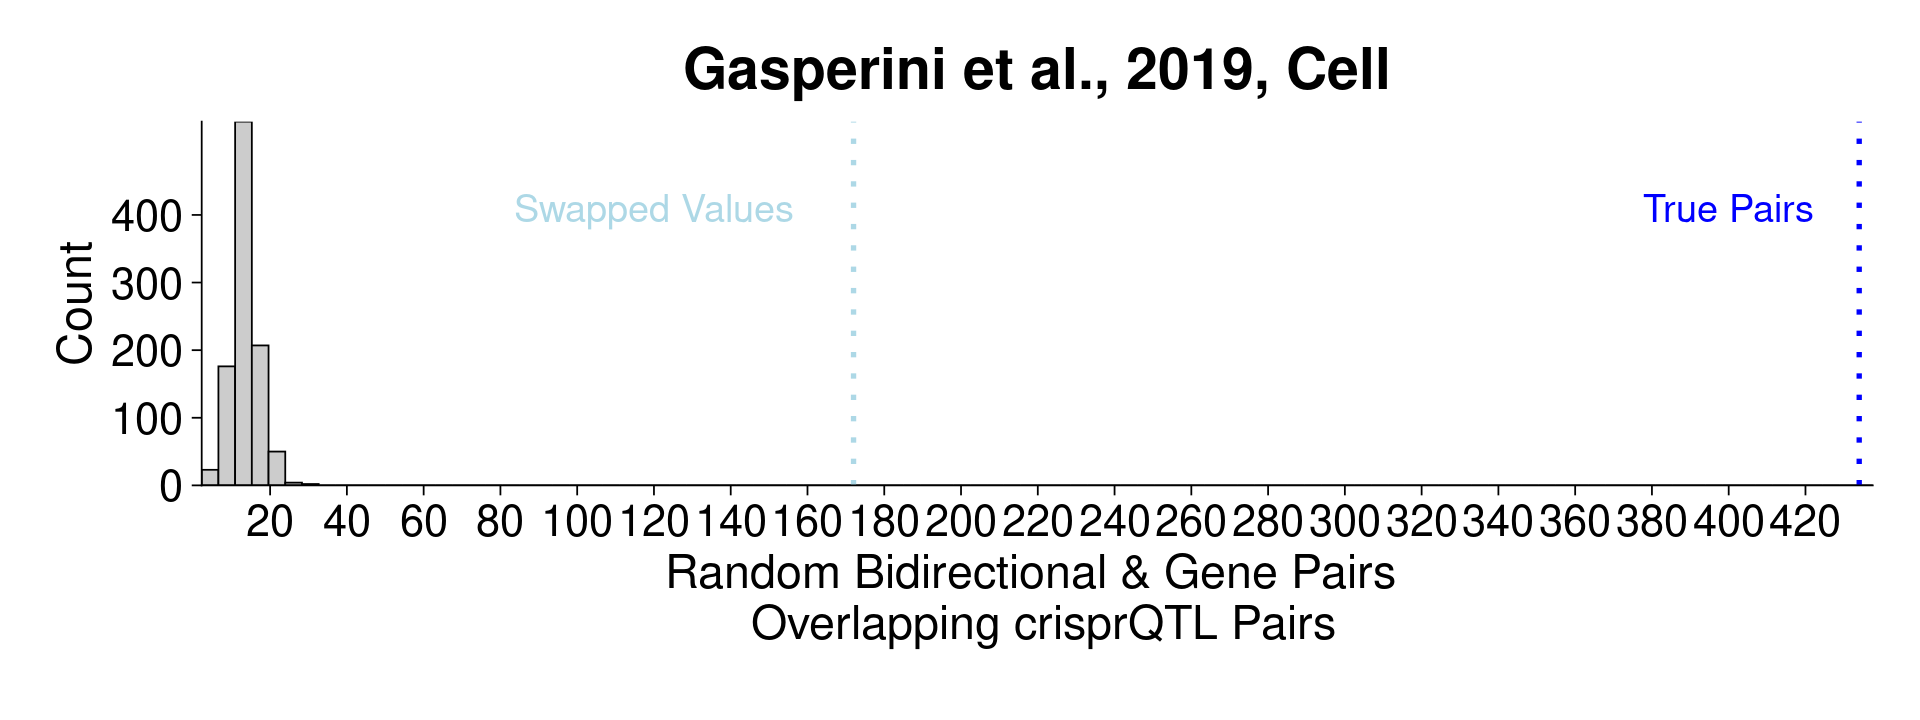

In [34]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotAnum <- ggplot(random_overlaps_1000, aes(x=random_overlap)) + 
geom_histogram(color="black", fill="gray80", bins = 100) +
geom_vline(xintercept = nrow(crisprQtl_bidirGene_overlaps),
           linetype="dotted", 
                color = "blue", size=1.5) +
geom_vline(xintercept = nrow(crisprQtl_bidirGene_overlaps_swapped),
           linetype="dotted", 
                color = "lightblue", size=1.5) +
scale_x_continuous(expand = c(0, 0),
                   #limits = c(0, 220),
                   breaks = seq(0,600,20)) +
scale_y_continuous(expand = c(0, 0),
                   #limits = c(0,450),
                   breaks = seq(0,450,100)) +
annotate(geom="text", size=8, x=400, y=410, label="True Pairs",
              color="blue") +
annotate(geom="text", size=8, x=120, y=410, label="Swapped Values",
              color="lightblue") +
theme_cowplot(24) +
  labs(title = "Gasperini et al., 2019, Cell", 
       y = "Count",
       x = "Random Bidirectional & Gene Pairs \n Overlapping crisprQTL Pairs") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(1,1,1.5,1.2, "cm"))

overlap_plotAnum

In [35]:
signif(mean(random_overlaps_1000$random_overlap))

[1] 13.468

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


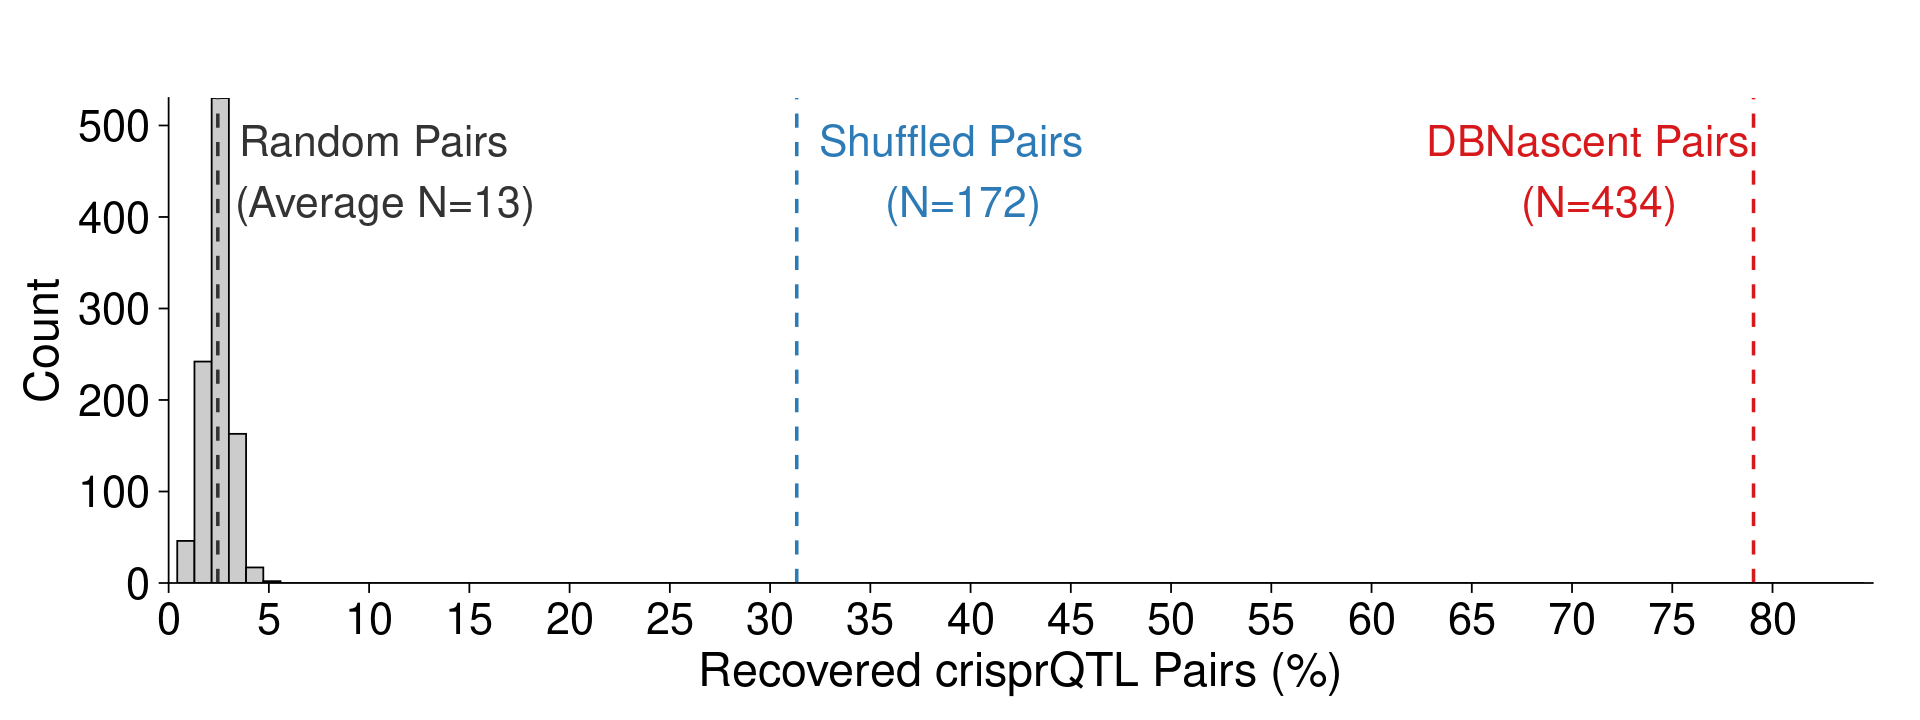

In [37]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotA <- ggplot(random_overlaps_1000, aes(x=percent_overlap_transcribed)) + 
geom_histogram(color="black", fill="gray80", bins = 100) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dashed", 
                color = "#d7191c", size=1) +
geom_vline(xintercept = percent_swapped_transcribed,
           linetype="dashed", 
            color = "#2c7bb6", size=1) +
geom_vline(xintercept = mean(random_overlaps_1000$percent_overlap_transcribed),
           linetype="dashed", 
            color = "gray20", size=1) +
scale_x_continuous(expand = c(0, 0),
                   limits = c(0, 85),
                   breaks=seq(0,80,5)) +
scale_y_continuous(expand = c(0, 0)) +
annotate(geom="text", size=9,
         x=percent_recovered_transcribed-8,
         y=450, 
         label=paste0("DBNascent Pairs \n (N=",
                      nrow(crisprQtl_bidirGene_overlaps),")"),
         color="#d7191c") +
annotate(geom="text", size=9,
         x=percent_swapped_transcribed+8,
         y=450, 
         label=paste0("Shuffled Pairs \n (N=",
                      nrow(crisprQtl_bidirGene_overlaps_swapped),")"),
         color="#2c7bb6") +
annotate(geom="text", size=9,
         x=signif(mean(random_overlaps_1000$percent_overlap_transcribed),
       2)+8,
         y=450, 
         label=paste0("Random Pairs \n (Average N=",
                      signif(mean(random_overlaps_1000$random_overlap),
       2),")"),
         color="gray20") +
#coord_cartesian(xlim=c(0,70), ylim=c(0,400)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plotA

In [38]:
ggsave(overlap_plotA, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gasperini_nascent_overlaps_percent_reviews.pdf',
       bg = "transparent")

ggsave(overlap_plotA, width = 16, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/gasperini_nascent_overlaps_percent_reviews.png',
       bg = "transparent")

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


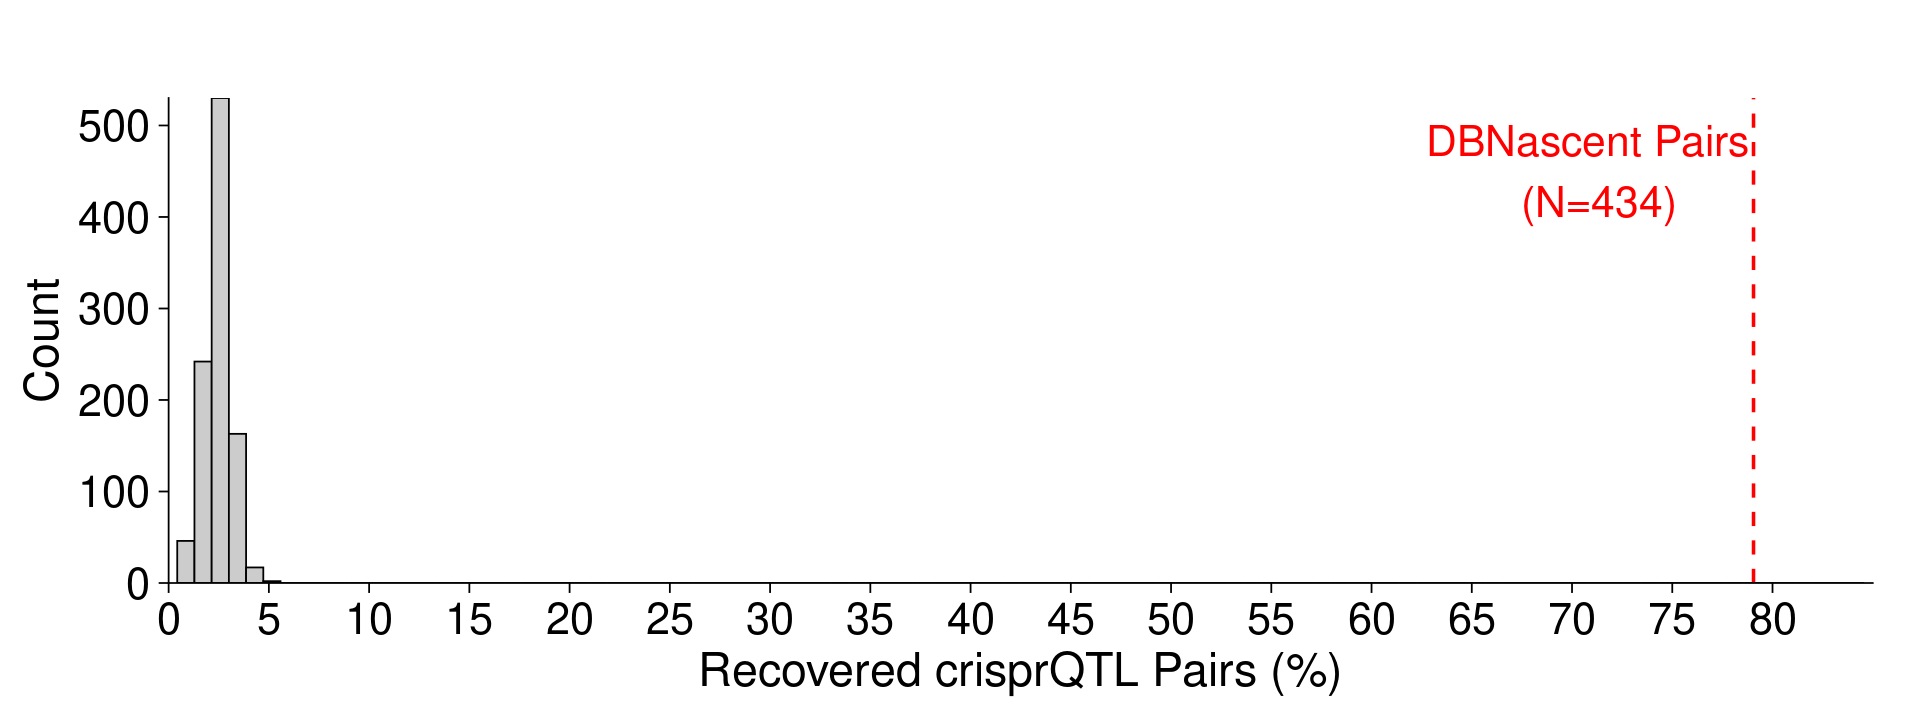

In [39]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotB <- ggplot(random_overlaps_1000, aes(x=percent_overlap_transcribed)) + 
geom_histogram(color="black", fill="gray80", bins = 100) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dashed", 
                color = "red", size=1) +
scale_x_continuous(expand = c(0, 0),
                   limits = c(0, 85),
                   breaks=seq(0,80,5)) +
scale_y_continuous(expand = c(0, 0)) +
annotate(geom="text", size=9,
         x=percent_recovered_transcribed-8,
         y=450, 
         label=paste0("DBNascent Pairs \n (N=",
                      nrow(crisprQtl_bidirGene_overlaps),")"),
         color="red") +
#coord_cartesian(xlim=c(0,70), ylim=c(0,400)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plotB

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


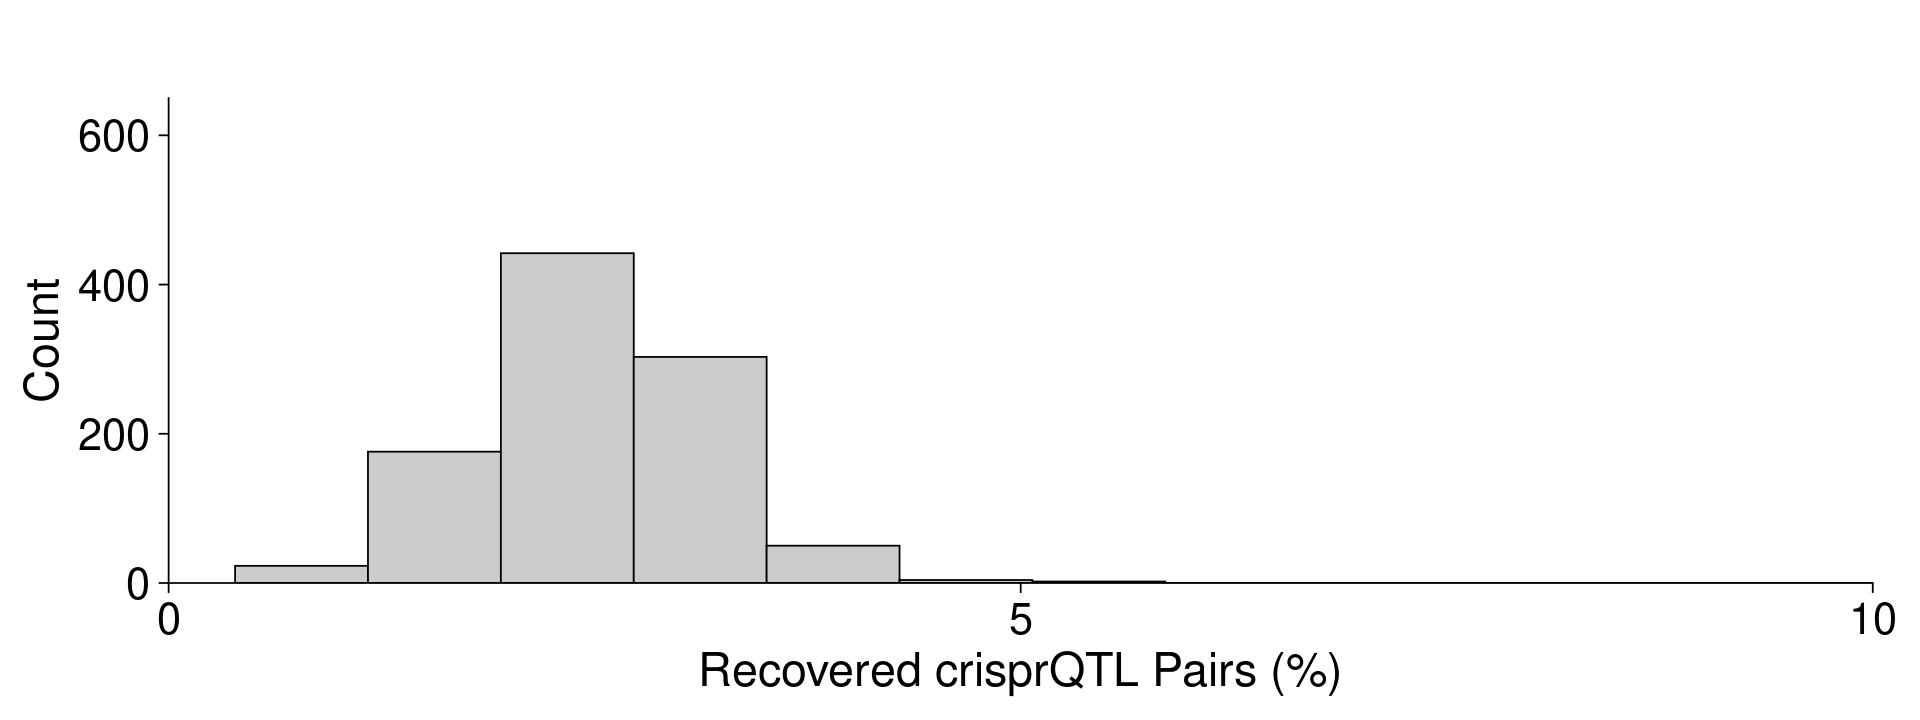

In [40]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotB_left <- ggplot(random_overlaps_1000, aes(x=percent_overlap_transcribed)) + 
geom_histogram(color="black", fill="gray80", bins = 110) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dashed", 
                color = "red", size=1) +
scale_x_continuous(expand = c(0, 0),
                   limits = c(0, 85),
                   breaks=seq(0,80,5)) +
scale_y_continuous(expand = c(0, 0)) +
annotate(geom="text", size=9,
         x=percent_recovered_transcribed-8,
         y=450, 
         label=paste0("DBNascent Pairs \n (N=",
                      nrow(crisprQtl_bidirGene_overlaps),")"),
         color="red") +
coord_cartesian(xlim=c(0,10), ylim=c(0,650)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))

overlap_plotB_left

# Session Information

In [41]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] data.table_1.16.2 cowplot_1.1.3     ggplot2_3.5.1    

loaded via a namespace (and not attached):
 [1] gtable_0.3.6      jsonlite_1.8.9    dplyr_1.1.4       compiler_4.4.0   
 [5] crayon_1.5.3      tidyselect_1.2.1  IRdisplay_1.1     textshaping